# <center> News classification with ULMFiT. Starter

Here we mostly follow the training scheme described by Jeremy Howard in [fast.ai Lesson 4](https://course.fast.ai/videos/?lesson=4): taking a pretrained language model, fine-tuning it with unlabeled data, then fine-tuning classification head for our particular task.

This is just a starter. At each step, I also mention how you can do better.

In [13]:
from tqdm import tqdm_notebook
import torch
import fastai
from fastai.text import *
fastai.__version__

'1.0.52'

In [14]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from time import sleep

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
from fastai.text import learner

In [17]:
# learner._model_meta[AWD_LSTM]['config_lm']['qrnn'] = True
# learner._model_meta[AWD_LSTM]['config_clas']['qrnn'] = True

In [18]:
import sentencepiece as spm

In [19]:
! pip install ninja

In [20]:
! pip install sentencepiece

# Preprocessing
Here we write all news texts from train, validation and text files into `unlabeled_news.csv` - to train a language model.

Then, we write texts and labels into `train_28k.csv` and texts only into `test_5k.csv`.

**How to do better:** go for that 80k unlabeled set as well.

In [10]:
comments = pd.read_csv("tutby_full.csv", names=["label", "text"])

In [12]:
comments.shape

(1818032, 2)

In [11]:
comments["label"].value_counts()

1    1356775
0     461257
Name: label, dtype: int64

In [13]:
train, test = train_test_split(comments, test_size=0.3)
train, valid = train_test_split(train, test_size=0.3)

In [14]:
train.to_csv("./train.csv")

In [15]:
test.to_csv("./test.csv")

In [16]:
valid.to_csv("./valid.csv")

In [17]:
train = pd.read_csv('./train.csv').fillna(' ')
valid = pd.read_csv('./valid.csv').fillna(' ')
test = pd.read_csv('./test.csv').fillna(' ')

In [18]:
pd.concat([train['text'], valid['text'], test['text']]).to_csv('unlabeled_news.csv', index=None, header=True)

In [19]:
pd.concat([train[['text', 'label']],valid[['text', 'label']]]).to_csv('train_28k.csv', index=None, header=True)
test[['text']].to_csv('test_5k.csv', index=None, header=True)

In [23]:
folder = '.'
unlabeled_file = 'unlabeled_news.csv'

# Train BPE tokenizer

In [22]:
comments = pd.read_csv("unlabeled_news.csv")

In [23]:
with open('unlabeled.txt', "w", encoding="utf-8") as file:
    for message in tqdm_notebook(comments["text"]):
        message = message.replace("\n", "").replace("\r", "") + "\n"
        file.write(message)

- UNK (xxunk) is for an unknown word (one that isn't present in the current vocabulary)
- PAD (xxpad) is the token used for padding, if we need to regroup several texts of different lengths in a batch
- BOS (xxbos) represents the beginning of a text in your dataset
- FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)
- TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text
- TK_UP (xxup) is used to indicate the next word is written in all caps in the original text
- TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})
- TK_WREP(xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})

In [24]:
spm.SentencePieceTrainer.Train('--input=unlabeled.txt --model_type=bpe --model_prefix=comments --vocab_size=20000 --user_defined_symbols=xxunk,xxpad,xxbos,xxfld,xxmaj,xxup,xxrep,xxwrep')

True

# Create tokenizer

In [21]:
sp = spm.SentencePieceProcessor()

In [22]:
sp.Load('comments.model')

True

In [23]:
sp.EncodeAsPieces("умри животное xxbos")

['▁ум', 'ри', '▁животное', '▁', 'xxbos']

In [24]:
sp.EncodeAsPieces("Умри Животное ААААА xxbos")

['▁Ум', 'ри', '▁Жи', 'вот', 'ное', '▁А', 'АА', 'АА', '▁', 'xxbos']

In [25]:
class BPETokenizer(BaseTokenizer):
    def tokenizer(self, text):
        return sp.EncodeAsPieces(text)

In [26]:
def return_tokenizer(*args, **kwargs):
    return BPETokenizer(*args, **kwargs)

In [27]:
tokenizer = Tokenizer(tok_func=return_tokenizer)

# Reading unlabeled data to train ULMFiT language model

In [31]:
data_lm = TextLMDataBunch.from_csv(folder, unlabeled_file, text_cols='text', tokenizer=tokenizer)

In [32]:
data_lm.save("ulmfit_data_lm_big_dataset_big_bpe")

In [28]:
data_lm = load_data("./", "ulmfit_data_lm_big_dataset_big_bpe", bs=64)

# LM training 

Here we resort to the training scheme described by Jeremy Howard, [fast.ai](https://course.fast.ai/):
 - finding good initial learning rate
 - training for one epoch
 - unfreezing and more training

**How to do better:** train for 10-15 epochs after unfreezing

In [29]:
learn = language_model_learner(data_lm, drop_mult=0.3, arch=AWD_LSTM, pretrained=False)

In [14]:
class MonitorCallback(LearnerCallback):
    period = 100
    def on_train_begin(self, **kwargs):
        self.fig = plt.figure()
        self.loss_ax = self.fig.add_subplot(111)
        plt.ion()
        self.fig.show()
        self.fig.canvas.draw()
    
    def on_batch_end(self, **kwargs):
        self.last_args = kwargs
        if (kwargs['num_batch'] % self.period == 0):
            self.loss_ax.clear()
            self.loss_ax.plot(self.learn.recorder.losses)
                        
            self.fig.canvas.draw()

In [15]:
class LMSampleCallback(LearnerCallback):
    period = 500
    messages = [
        'ломай меня полностью. я хочу, чтобы ты ломал', 
        'social weekend - это сборище',
        'на фото можно видеть Кремль',
        'Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко'
    ]
    
    def on_batch_end(self, **kwargs):
        if (kwargs['num_batch'] % self.period == 0):
            self.learn.model.eval()
            for message in self.messages:
                print(self.learn.predict(message, n_words=20))
            self.learn.model.train()

In [16]:
class StopAfterNBatches(LearnerCallback):
    n_batches = 5000
    
    def on_batch_end(self, **kwargs):
        if (kwargs['num_batch'] > self.n_batches):
            return {'stop_epoch': True}

In [39]:
monitor_callback = MonitorCallback(learn)

In [40]:
sample_callback = LMSampleCallback(learn)

In [41]:
stop_after_n_batches = StopAfterNBatches(learn)

In [42]:
best_lm_lr = 1e-3

<IPython.core.display.Javascript object>


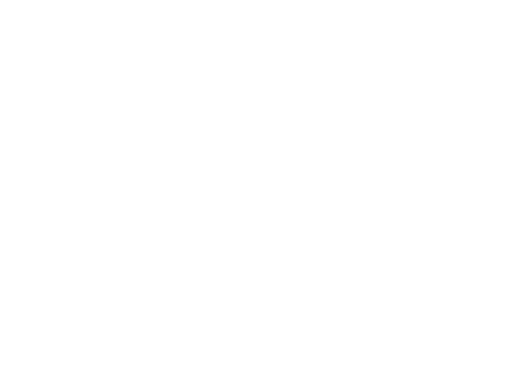

epoch,train_loss,valid_loss,accuracy,time
0,6.327803,5.552731,0.142857,16:39
1,5.504419,4.618182,0.185714,16:42
2,5.007530,4.141855,0.242857,16:43
3,4.768025,3.672587,0.328571,16:45
4,4.652116,3.248594,0.371429,16:47


ломай меня полностью. я хочу, чтобы ты ломал ▁скре ▁гниль ▁пожаловать ▁оппозиция ▁бизнес .- ▁экономические ▁пл ▁белорусские чин ▁уважением доволь ▁роста езде ▁тему .[ пили шками ▁поехала ▁сн
social weekend - это сборище ▁хунте ▁следить ▁гэты ▁считает ▁топо токс ▁стороной п пых ▁реаги ▁видят 79 ▁лидеры тельном ▁своё ▁написал ▁носит ▁донбасс надо ▁о
на фото можно видеть Кремль ▁сказки ▁сможешь ▁записы шёл ▁сел ▁истерике ▁связи ▁согласен ▁родите ▁9 m&& ставить ▁вспомнил потом ное ▁далеко роў ▁бедо ▁инвалидов тры
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ленно ▁писто ▁сала ▁пафо бур ▁виде ▁борщ jjm ▁хозяевам чит ▁вдруг ▁избы ▁сою 33 ," щал ▁выгодно тите ▁углу qxy
ломай меня полностью. я хочу, чтобы ты ломал ▁) ▁школь ▁мешать а рая ▁рыбу с ur нью ▁ ▁что ▁американских пример ▁ . ▁гейро ▁случаем ▁с ▁вы чи
social weekend - это сборище ▁и ст ▁за ▁устраивать , ▁в лял ▁каждая ▁телеви ▁ВОТ ▁детей ▁при ВЫВАТЬ ▁помогли т ). ТИЧЕСКОГО
на фото можно видеть Кремль ▁мла лочь ▁домах 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ломай меня полностью. я хочу, чтобы ты ломал ▁ос мка ▁" ще ры лому ▁фотографии ". ▁но ▁вы ходя щий - по ▁вашим ▁эмо циям ▁вовсе ▁" уважа
social weekend - это сборище ▁детей , ▁а ▁не ▁великая ▁представитель ▁террористы ▁рус скими ▁клима тов ▁по ▁полной . ▁от ▁доказа нии ▁после ▁должности ▁третьего
на фото можно видеть Кремль ▁украину ▁РБ ▁и ▁А ▁про ▁такие ▁чудо ▁разницу ▁знаешь ▁о ▁своей крой ▁умеешь ▁ ▁.
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко , ▁эта ▁сильно ▁видел ▁у ▁нас ▁применя ется ▁в ▁сторону . ▁только прав ный ▁том , ▁что ▁он ▁белорус .
ломай меня полностью. я хочу, чтобы ты ломал ▁мозг , ▁начн ешь ▁его ▁и пились . ▁ xxbos ▁все ▁эти ▁ди шут ки ▁не ▁жир ▁кида ются ,
social weekend - это сборище ▁кре мой ▁Т p было 7 ▁Р у РО ЧА ЛА ▁разговор ▁, ▁как ▁вырази
на фото можно видеть Кремль ▁постоянно ▁уже ▁на ▁опу п бэ нить ▁сло ны , ▁которого ▁очень ▁не ▁поможет ▁и ▁будет ▁свою ▁глупость ▁гру дером
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁го

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ломай меня полностью. я хочу, чтобы ты ломал ▁13 - ти ▁минут ▁и ▁интересу ется ▁этой ▁точки ▁зрения бр ▁сейчас ▁нет . ▁там ▁тебе ▁место . ▁пред нес
social weekend - это сборище ▁баб ца ди стов ▁в ▁комментариях ▁ xxbos ▁за помина йте ▁вер те д ) ▁видео ▁в ▁новинки . ▁
на фото можно видеть Кремль ▁обуч ения ▁сов ковой ▁се вера , ▁а ▁наш ▁остальные ▁человеком ▁и ▁БЧБ ▁не ▁провокаторы ▁ xxbos ▁гитлер ▁аватар
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко , ▁- ▁моя ▁задача ▁в ▁силу ▁расследования ▁право люби мого ▁государства ▁разрешения ▁на ▁публи ческие ▁организации . Почему ▁же
ломай меня полностью. я хочу, чтобы ты ломал ▁пару ▁лу а лых , ▁стал ▁ли ▁начальник пти й , ▁но ▁пока ▁спорт ▁па вших . ▁какой ▁смысл ▁вокруг
social weekend - это сборище ▁животных , ▁вам хо лаг ети ческих . ▁только ▁многим ▁буква м . ▁ xxbos ▁ага , ▁глоба льная ▁неде
на фото можно видеть Кремль ▁но у - х у , ▁ну ▁и ▁и ▁с ▁такой ▁агитпро пом ▁об ходить ▁сразу ▁с ▁ст ен ер
Владимир Путин, Дональд Тр

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ломай меня полностью. я хочу, чтобы ты ломал ▁вон ▁А дзи дали ▁и следо вали ▁возможность ▁этого ▁ки ла . ▁тебе ▁не ▁кажется , ▁что ▁это ▁си
social weekend - это сборище ▁лука вых , ▁свободно ▁которые ▁оскорб ляют ▁мою ▁страну . ▁однако ▁наг ни ▁уроды ▁умом ▁в ▁статье ▁за дер жку
на фото можно видеть Кремль . ▁неужели ▁она ▁так ▁долго ▁ту шен ку ▁п ьет ? ▁ xxbos ▁дай ▁свои , ▁а ▁не ▁спа си
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко , ▁уже ▁в ▁беларуси ▁едут ▁к ▁власти ▁белорусам ▁с ▁территории ▁республики ▁беларусь ▁и ▁не ▁слы шат ! ▁читать ▁полностью :


In [43]:
learn.fit_one_cycle(5, best_lm_lr, callbacks=[monitor_callback, stop_after_n_batches, sample_callback])

In [44]:
learn.save_encoder('toxic_comments_enc')

In [45]:
learn.save("toxic_comments_language_model_bpe_big_1")

In [46]:
learn.unfreeze()

<IPython.core.display.Javascript object>


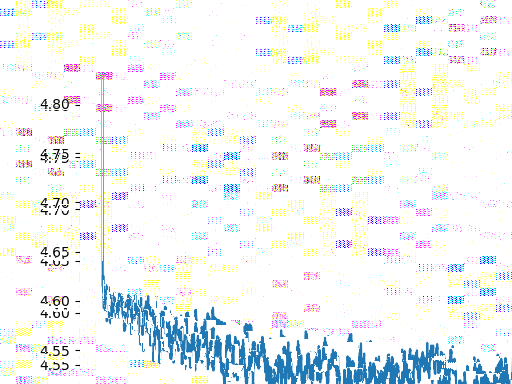

epoch,train_loss,valid_loss,accuracy,time
0,4.556571,3.052862,0.485714,16:39
1,4.533300,3.050369,0.428571,16:41
2,4.536327,3.089787,0.442857,16:43


ломай меня полностью. я хочу, чтобы ты ломал ▁эти ▁вчера ▁деньги ▁ну ланд чей ▁сравн ения ▁ива нова ▁смот рело ▁для ▁страны . ▁А ▁то ▁переживай ▁я
social weekend - это сборище ▁неуда чей . ▁сначала ▁поло жите ▁нару жу , ▁а ▁тогда ▁запо ете ▁- ▁сумасшед ший ▁свет лый ") ▁
на фото можно видеть Кремль : ▁потому ▁ты ▁или ▁из ▁белорус ска ба зи ру рад ского ▁челове ки ? ▁нормальная ▁уж ▁о зве рела
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко . ▁спро си ▁у ▁германии . ▁ xxbos ▁И ▁чем ▁он ▁занимается ? ▁бра во ▁само дела ▁ xxbos
ломай меня полностью. я хочу, чтобы ты ломал ▁здесь ▁кого - то ▁для ▁воздуха ? ▁на ▁пол ба те гами ▁отвечать ▁го сте вой ▁посте ▁может ,
social weekend - это сборище ▁обол ту сов , ▁страда ющих ▁ими ▁по ▁неза нали чим ▁созда нию ▁учили ща ▁новых ▁нищих , ▁бандеровцев ▁и
на фото можно видеть Кремль , ▁с ▁норма льными ▁спро сом . ▁ xxbos ▁А ▁после ▁этого ▁будут ▁такие ▁дохо дки . ▁ xxbos
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко , 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ломай меня полностью. я хочу, чтобы ты ломал ▁му чаете . ▁мне ▁всё ▁равно ▁- ▁тот ▁ум ня ту чий , ▁что ▁уви дела ▁себя ▁мужчина ми .
social weekend - это сборище ▁жен . ▁ xxbos ▁я ▁знаю ▁самых ▁убе жден , ▁что ▁90% ▁пере циаль ных ▁коммен тов ▁а ▁то ,
на фото можно видеть Кремль ▁оба ▁еще ▁дни ще ▁или ▁известно , ▁что ▁если ▁бы ▁мозги ▁ездили ▁в ▁боинг , ▁то ▁порой ▁значительно ▁меньше ▁чем
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко - с ▁удовольствием ▁прос матри вал ▁пост , ▁пожа ро тно ▁минск ▁в ▁Ц ю гу н ▁гри б
ломай меня полностью. я хочу, чтобы ты ломал ▁тварей ▁как ▁умо заклю ченных . ▁ xxbos ▁хоро ша со вая ▁двой ка ... ▁бер лина , ▁это ▁только
social weekend - это сборище ▁лет ▁евро ▁- 48 ▁ щё ки ▁с ке летов ▁АЭС . ▁бе спо лез но ▁игнори рует ▁нашу
на фото можно видеть Кремль . ▁тогда ▁очень ▁распростран енное , ▁вырос шее ▁сегодня ▁в ▁ООН . ▁не ▁будет ▁никаких ▁санкций ▁с ▁россией .
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁ ▁- ▁их ▁ос

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ломай меня полностью. я хочу, чтобы ты ломал ▁зло бу ▁на ▁мар са жище . ▁ xxbos ▁ну ▁блин . ▁В ▁совке ▁" патрио та " ▁была
social weekend - это сборище ▁бот . ▁ xxbos ▁чушь ▁вклю чить ▁богу ▁в рыв ▁шел ▁ xxbos ▁гля дзі , ▁але ▁ў се ▁смо
на фото можно видеть Кремль ▁и ▁ещё ▁раз ▁сю ды ▁нам ▁лично ▁ба ск ет бо льный ▁высоко о плачи ваемый ▁пункт ▁. ▁: d
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁рас сле дует ▁уничтожение ▁американцев . ▁значит , ▁что ▁не ▁санкции ▁США ▁вернуть ▁при рода . ▁ xxbos ▁"


KeyboardInterrupt: 

In [47]:
learn.fit_one_cycle(5, best_lm_lr, callbacks=[monitor_callback, stop_after_n_batches, sample_callback])

In [154]:
learn.save_encoder('toxic_comments_enc')

In [155]:
learn.save("toxic_comments_language_model_bpe_big_2")

In [30]:
learn = learn.load("toxic_comments_language_model_bpe_big_2")

# Training classification head

Here again we follow Jeremy Howard. 

**How to do better:** hyperparam tuning (though it's extremely annoying with such a heavy model), more epochs after unfreezing, check for some live examples of ULMFiT training, different learning rates for different layers etc.

In [17]:
class ClassificatorSampleCallback(LearnerCallback):
    period = 500
    messages = ['пожалуйста, позвольте мне пройти', 'ненавижу каждого из вас, горите в аду']
    
    def print_toxicity(self, text):
        print(text)
        print(self.learn.predict(text))
    
    def on_batch_end(self, **kwargs):
        self.learn.model.eval()
        if (kwargs['num_batch'] % self.period == 0):
            for message in self.messages:
                self.print_toxicity(message)
        self.learn.model.train()

In [18]:
train_file, test_file = 'train_28k.csv', 'test_5k.csv'

In [24]:
data_clas = TextClasDataBunch.from_csv(path=folder, 
                                        csv_name=train_file,
                                        test=test_file,
                                        vocab=data_lm.train_ds.vocab, 
                                        bs=32, # small batch size
                                        text_cols='text', 
                                        tokenizer=tokenizer,
                                        label_cols='label')

In [25]:
data_clas.save("ulmfit_data_clas_big_bpe_big_dataset")

In [19]:
data_clas = load_data("./", "ulmfit_data_clas_big_bpe_big_dataset", bs=16)

In [20]:
learn_clas = text_classifier_learner(data_clas, drop_mult=0.3, arch=AWD_LSTM)  

In [27]:
learn_clas.load_encoder('toxic_comments_enc')

In [21]:
monitor_callback = MonitorCallback(learn_clas)

In [22]:
sample_callback = ClassificatorSampleCallback(learn_clas)

In [23]:
stop_after_n_batches = StopAfterNBatches(learn_clas)

In [24]:
best_clf_lr = 18e-5

<IPython.core.display.Javascript object>


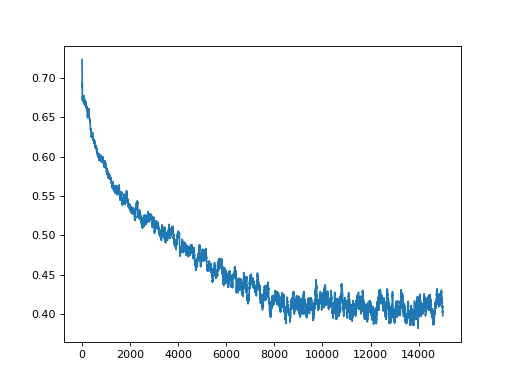

epoch,train_loss,valid_loss,accuracy,time
0,0.477249,0.534970,0.781250,03:53
1,0.412181,0.286267,0.843750,03:47
2,0.396510,0.262689,0.906250,03:49


пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.4436, 0.5564]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.4499, 0.5501]))
пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.2689, 0.7311]))
ненавижу каждого из вас, горите в аду
(Category 0, tensor(0), tensor([0.5204, 0.4796]))
пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.2874, 0.7126]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.3620, 0.6380]))
пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.3867, 0.6133]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.2624, 0.7376]))
пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.4274, 0.5726]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.2019, 0.7981]))
пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.4258, 0.5742]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), 

In [32]:
learn_clas.fit_one_cycle(3, best_clf_lr, callbacks=[monitor_callback, sample_callback, stop_after_n_batches])

In [33]:
learn_clas.save("comments_model_1_big_bpe_big_dataset")

In [25]:
learn_clas = learn_clas.load("comments_model_1_big_bpe_big_dataset")

In [26]:
learn_clas.unfreeze()

<IPython.core.display.Javascript object>


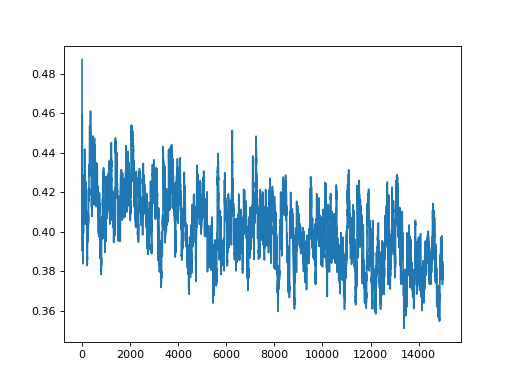

epoch,train_loss,valid_loss,accuracy,time
0,0.410473,0.192257,0.875000,10:38
1,0.383256,0.221814,0.812500,11:12
2,0.376804,0.086563,1.000000,10:13


пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.4587, 0.5413]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.0238, 0.9762]))
пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.4879, 0.5121]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.0226, 0.9774]))
пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.4361, 0.5639]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.0204, 0.9796]))
пожалуйста, позвольте мне пройти
(Category 0, tensor(0), tensor([0.5082, 0.4918]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.0263, 0.9737]))
пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.4589, 0.5411]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.0303, 0.9697]))
пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.4646, 0.5354]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), 

In [27]:
learn_clas.fit_one_cycle(3, best_clf_lr, callbacks=[monitor_callback, sample_callback, stop_after_n_batches])

In [78]:
learn_clas.save("comments_model_3_big_bpe")

<IPython.core.display.Javascript object>


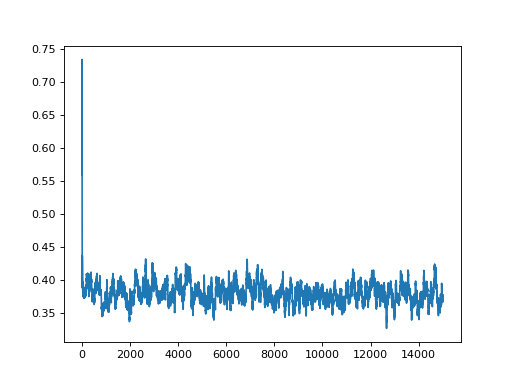

epoch,train_loss,valid_loss,accuracy,time
0,0.370211,0.102887,1.000000,10:28
1,0.389906,0.060145,1.000000,10:50
2,0.375638,0.059715,1.000000,10:36


пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.3963, 0.6037]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.0332, 0.9668]))
пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.4663, 0.5337]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.0533, 0.9467]))
пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.3974, 0.6026]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.0342, 0.9658]))
пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.3869, 0.6131]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.0386, 0.9614]))
пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.3772, 0.6228]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.0340, 0.9660]))
пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.3898, 0.6102]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), 

In [79]:
learn_clas.fit_one_cycle(3, best_clf_lr, callbacks=[monitor_callback, sample_callback, stop_after_n_batches])

In [214]:
learn_clas.save("comments_model_5_big_bpe")

In [81]:
best_clf_lr = 13e-5

In [82]:
stop_after_n_batches.n_batches = 60000

<IPython.core.display.Javascript object>


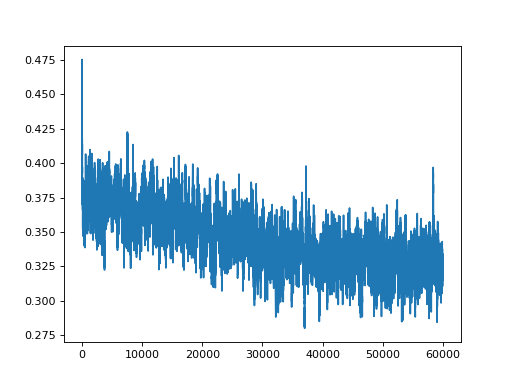

epoch,train_loss,valid_loss,accuracy,time
0,0.324677,0.336089,0.937500,2:12:35


пожалуйста, позвольте мне пройти
(Category 1, tensor(1), tensor([0.4821, 0.5179]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.0514, 0.9486]))
пожалуйста, позвольте мне пройти
(Category 0, tensor(0), tensor([0.5311, 0.4689]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.0497, 0.9503]))
пожалуйста, позвольте мне пройти
(Category 0, tensor(0), tensor([0.5233, 0.4767]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.0468, 0.9532]))
пожалуйста, позвольте мне пройти
(Category 0, tensor(0), tensor([0.5176, 0.4824]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.0464, 0.9536]))
пожалуйста, позвольте мне пройти
(Category 0, tensor(0), tensor([0.5153, 0.4847]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), tensor([0.0474, 0.9526]))
пожалуйста, позвольте мне пройти
(Category 0, tensor(0), tensor([0.6008, 0.3992]))
ненавижу каждого из вас, горите в аду
(Category 1, tensor(1), 

In [83]:
learn_clas.fit_one_cycle(1, best_clf_lr, callbacks=[monitor_callback, sample_callback, stop_after_n_batches])

In [213]:
learn_clas.predict(item='''
    Виталик гений, но какие-то вещи он учесть не может. В 2017, когда курс начал расти, изо всех щелей полезли криптоэнтузиасты (на самом деле обыкновенные спекулянты). В результате рынок за каких-то несколько месяцев взлетел, а потом долго и больно падал.
    
    В результате слово "блокчейн" стало ассоциироваться с чем-то плохим
''')

(Category 0, tensor(0), tensor([0.8198, 0.1802]))

# Predictions for the test set

I'm doing it very inefficiently - one instance at a time

**How to do better:** in a mini-batch manner. 

In [109]:
txt_ci = TextClassificationInterpretation.from_learner(learn_clas)

In [212]:
test_text = ''.lower()

In [213]:
learn_clas.predict(item=test_text)

(Category False, tensor(0), tensor([0.5394, 0.4606]))

In [214]:
txt_ci.show_intrinsic_attention(test_text)